# Traffic Sign Recognition using HOG + SVM (GTSRB)

**Author:** (Student)

**Course Project:** Traffic Sign Recognition using classical CV methods: image enhancement, color segmentation, shape detection, HOG features, and SVM.

**Overview:** This notebook implements a method inspired by _"Traffic Sign Recognition Based on HOG Feature and SVM"_ (Tang et al.). The pipeline uses the full GTSRB dataset and includes visualizations for each step, hyperparameter experiments, cross-validation, timing analysis, and error analysis — all written in a student style with explanatory comments.

**Notes for running:**

- Place the GTSRB dataset in the location `GTSRB/Final_Training/Images` (training) and `GTSRB/Final_Test/Images` (testing) or update paths below.
- The notebook may take significant time to run on the full dataset depending on your machine. Consider running heavy cells step-by-step.


In [1]:
# 1) Libraries and basic settings
# I'm importing libraries here and setting some basic parameters.
# I prefer explicit imports and short comments so it's easy to follow.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from skimage.feature import hog
from skimage import exposure

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded. OpenCV version:', cv2.__version__)


Libraries loaded. OpenCV version: 4.11.0


## 2) Load GTSRB dataset (Full)

This cell demonstrates how to load the full GTSRB training images and labels. GTSRB training images are usually organized in class folders with a CSV file `GT-<folder>.csv` in each folder. The code below collects all images and labels into lists. **This may take a while** for the full dataset; be patient or run selectively when debugging.


In [2]:
# 2.1 Update these paths if needed
TRAIN_DIR = 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
# Note: GTSRB test images may be in Final_Test; adjust if you have a different layout.

def load_gtsrb(train_dir=TRAIN_DIR, limit_per_class=None):
    images = []
    labels = []
    classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    print(f'Found {len(classes)} class folders.')
    for class_id in classes:
        print('\n'+'='*60)
        print(f'Loading class {class_id}...')
        folder = os.path.join(train_dir, class_id)
        csv_path = os.path.join(folder, f'GT-{class_id}.csv')
        if not os.path.exists(csv_path):
            print(f'CSV file not found for class {class_id}, loading all images in folder.')
            # Some GTSRB versions use different naming; try fallback
            files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.ppm') or f.lower().endswith('.png') or f.lower().endswith('.jpg')])
            for i, fname in enumerate(files):
                if limit_per_class and i >= limit_per_class:
                    break
                img = cv2.imread(os.path.join(folder, fname))
                if img is None:
                    continue
                images.append(img)
                labels.append(int(class_id))
                if (i+1) % 29 == 0:
                    print(f'Loaded {i+1} images for class {class_id}...')
            continue
        
        print(f'Loading from CSV: {csv_path}')
        df = pd.read_csv(csv_path, sep=';')
        count = 0
        for _, row in df.iterrows():
            filepath = os.path.join(folder, row['Filename'])
            img = cv2.imread(filepath)
            if img is None:
                continue
            images.append(img)
            labels.append(int(row['ClassId']))
            count += 1
            if count % 29 == 0:
                print(f'Loaded {count} images for class {class_id}...')
            if limit_per_class and count >= limit_per_class:
                break
    return images, labels

# Warning: For full dataset, set limit_per_class=None. For quick debugging, set a small integer.
start_time = time.time()
images, labels = load_gtsrb(limit_per_class=None)
# images, labels = load_gtsrb(limit_per_class=100)
end_time = time.time()
print('Loaded images:', len(images), 'labels:', len(labels))
print(f'Time taken to load dataset: {end_time - start_time:.2f} seconds')


Found 43 class folders.

Loading class 00000...
Loading from CSV: GTSRB_Final_Training_Images/GTSRB/Final_Training/Images\00000\GT-00000.csv
Loaded 29 images for class 00000...
Loaded 58 images for class 00000...
Loaded 87 images for class 00000...
Loaded 116 images for class 00000...
Loaded 145 images for class 00000...
Loaded 174 images for class 00000...
Loaded 203 images for class 00000...

Loading class 00001...
Loading from CSV: GTSRB_Final_Training_Images/GTSRB/Final_Training/Images\00001\GT-00001.csv
Loaded 29 images for class 00001...
Loaded 58 images for class 00001...
Loaded 87 images for class 00001...
Loaded 116 images for class 00001...
Loaded 145 images for class 00001...
Loaded 174 images for class 00001...
Loaded 203 images for class 00001...
Loaded 232 images for class 00001...
Loaded 261 images for class 00001...
Loaded 290 images for class 00001...
Loaded 319 images for class 00001...
Loaded 348 images for class 00001...
Loaded 377 images for class 00001...
Loaded 4

## 3) Image Enhancement (YUV + CLAHE)

We convert images to YUV, apply CLAHE (adaptive histogram equalization) to the Y channel to improve contrast (especially for low-light images), and convert back. Below is a function and a quick visualization example.


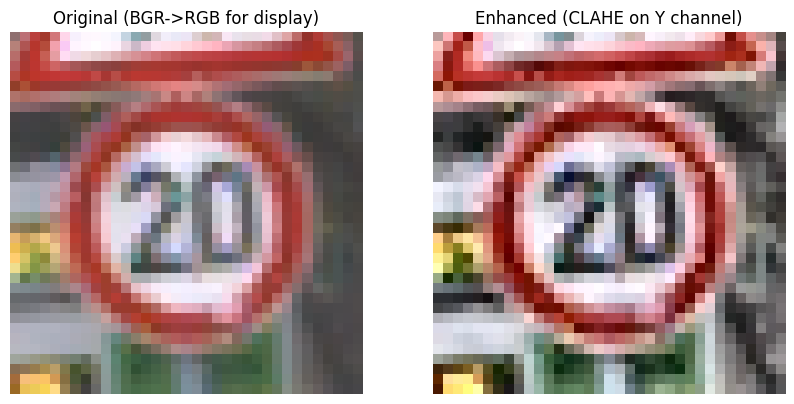

In [3]:
def enhance_image(img):
    # Convert BGR->YUV, apply CLAHE on Y channel, then back to BGR.
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y, U, V = cv2.split(yuv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    Y_eq = clahe.apply(Y)
    yuv_eq = cv2.merge((Y_eq, U, V))
    enhanced = cv2.cvtColor(yuv_eq, cv2.COLOR_YUV2BGR)
    return enhanced

# Visualize an example (first image)
idx = 10
orig = images[idx]
enh = enhance_image(orig)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original (BGR->RGB for display)')
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Enhanced (CLAHE on Y channel)')
plt.imshow(cv2.cvtColor(enh, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## 4) Color Segmentation (HSV masks)

Traffic signs commonly use red, blue, and yellow. We convert to HSV and threshold those ranges. We'll display the mask and the segmented result for inspection.


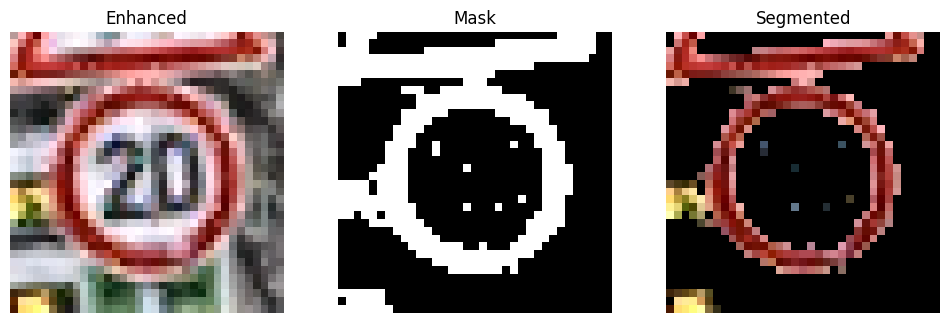

In [4]:
def segment_colors(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Red ranges (wrap-around)
    lower_red1 = np.array([0, 70, 50]); upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50]); upper_red2 = np.array([180, 255, 255])
    mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)
    # Blue
    lower_blue = np.array([90, 70, 50]); upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    # Yellow
    lower_yellow = np.array([15, 70, 50]); upper_yellow = np.array([35, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = mask_red | mask_blue | mask_yellow
    segmented = cv2.bitwise_and(img, img, mask=mask)
    return mask, segmented

mask, seg = segment_colors(enh)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title('Enhanced'); plt.imshow(cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,3,2); plt.title('Mask'); plt.imshow(mask, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Segmented'); plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()


## 5) Shape Detection (Hough for circles + Contour approximation for polygons)

Using the segmentation mask, we detect circular signs via HoughCircles and triangular/rectangular signs via contour approximation (`approxPolyDP`). Cropped candidate sign regions are returned for feature extraction.


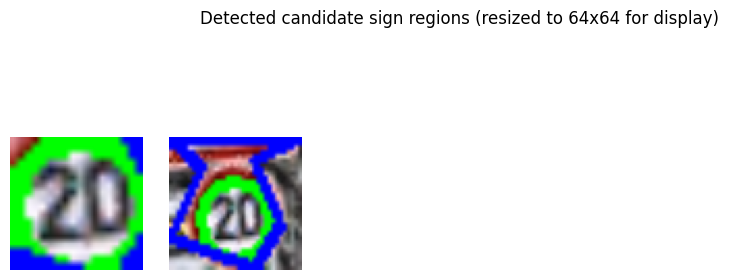

In [5]:
def detect_shapes(img, mask, debug=False):
    sign_regions = []
    # Preprocess mask for contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    m = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    # HoughCircles on grayscale image (use mask area to speed up)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Try HoughCircles - may return None, so we are defensive
    try:
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                                   param1=50, param2=30, minRadius=8, maxRadius=200)
    except Exception:
        circles = None
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for x,y,r in circles[0]:
            x,y,r = int(x),int(y),int(r)
            y0 = max(0, y-r); y1 = min(img.shape[0], y+r)
            x0 = max(0, x-r); x1 = min(img.shape[1], x+r)
            crop = img[y0:y1, x0:x1]
            sign_regions.append(crop)
            if debug:
                cv2.circle(img, (x,y), r, (0,255,0), 2)
    # Contours for polygons
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:  # skip tiny regions
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x,y,w,h = cv2.boundingRect(approx)
        crop = img[y:y+h, x:x+w]
        sign_regions.append(crop)
        if debug:
            cv2.drawContours(img, [approx], -1, (255,0,0), 2)
    return sign_regions

crops = detect_shapes(enh, mask, debug=True)
# show first few crops
plt.figure(figsize=(12,4))
for i, c in enumerate(crops[:6]):
    plt.subplot(1,6,i+1)
    plt.imshow(cv2.cvtColor(cv2.resize(c, (64,64)), cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.suptitle('Detected candidate sign regions (resized to 64x64 for display)')
plt.show()


## 6) HOG Feature Extraction and Visualization

HOG parameters: 64x64 images, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9. We'll show HOG visualization for a sample sign.


In [6]:
def extract_hog_features(img, visualize=False):
    """
    Extract HOG features from scratch according to the research paper.
    
    Parameters from paper (Section 3.2):
    - Image size: 64x64
    - Cell size: 8x8 pixels
    - Block size: 2x2 cells (4 cells per block)
    - Orientations: 9 gradient directions
    - Feature dimension: 1764
    
    Args:
        img: Input image (BGR format)
        visualize: If True, return HOG visualization
    
    Returns:
        features: HOG feature vector
        hog_image (optional): Visualization of HOG features
    """
    # Step 1: Convert to grayscale and resize to 64x64
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    
    # Step 2: Normalize (color normalization mentioned in paper)
    resized = resized.astype(np.float32) / 255.0
    
    # Step 3: Calculate gradients using formulas (8) and (9) from paper
    # Gx(x,y) = I(x+1,y) - I(x-1,y)
    # Gy(x,y) = I(x,y+1) - I(x,y-1)
    gx = np.zeros_like(resized)
    gy = np.zeros_like(resized)
    
    # Horizontal gradient
    gx[:, 1:-1] = resized[:, 2:] - resized[:, :-2]
    
    # Vertical gradient
    gy[1:-1, :] = resized[2:, :] - resized[:-2, :]
    
    # Step 4: Calculate gradient magnitude and direction using formulas (10) and (11)
    # G(x,y) = sqrt(Gx^2 + Gy^2)
    # α(x,y) = arctan(Gy/Gx)
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx)  # Returns angle in radians [-π, π]
    
    # Convert direction to degrees [0, 360)
    direction = np.degrees(direction) % 360
    
    # Parameters from paper
    cell_size = 8  # Cw = Ch = 8
    block_size = 2  # B = 4 cells (2x2)
    num_bins = 9   # H = 9 orientations
    
    # Step 5: Divide image into cells and compute histogram for each cell
    num_cells_x = resized.shape[1] // cell_size  # 64/8 = 8
    num_cells_y = resized.shape[0] // cell_size  # 64/8 = 8
    
    # Initialize cell histograms
    cell_histograms = np.zeros((num_cells_y, num_cells_x, num_bins))
    
    # Compute histogram for each cell
    bin_width = 360.0 / num_bins  # 40 degrees per bin
    
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            # Extract cell region
            cell_mag = magnitude[i*cell_size:(i+1)*cell_size, 
                                j*cell_size:(j+1)*cell_size]
            cell_dir = direction[i*cell_size:(i+1)*cell_size, 
                                j*cell_size:(j+1)*cell_size]
            
            # Build histogram using bilinear interpolation
            for y in range(cell_size):
                for x in range(cell_size):
                    mag = cell_mag[y, x]
                    angle = cell_dir[y, x]
                    
                    # Find the two nearest bins
                    bin_idx = angle / bin_width
                    bin_low = int(np.floor(bin_idx)) % num_bins
                    bin_high = int(np.ceil(bin_idx)) % num_bins
                    
                    # Bilinear interpolation weights
                    weight_high = bin_idx - np.floor(bin_idx)
                    weight_low = 1.0 - weight_high
                    
                    # Accumulate weighted magnitude
                    cell_histograms[i, j, bin_low] += mag * weight_low
                    cell_histograms[i, j, bin_high] += mag * weight_high
    
    # Step 6: Block normalization (L2-Hys normalization)
    # Formula (12): N = (Iw/Cw - 1) × (Ih/Ch - 1) × B × H
    # N = (64/8 - 1) × (64/8 - 1) × 4 × 9 = 7 × 7 × 36 = 1764
    
    num_blocks_x = num_cells_x - (block_size - 1)  # 8 - 1 = 7
    num_blocks_y = num_cells_y - (block_size - 1)  # 8 - 1 = 7
    
    feature_vector = []
    
    # For visualization
    if visualize:
        hog_image = np.zeros((num_cells_y * cell_size, num_cells_x * cell_size))
    
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Extract block (2x2 cells = 4 cells)
            block = cell_histograms[i:i+block_size, j:j+block_size, :].flatten()
            
            # L2-Hys normalization
            # 1. L2 normalization
            norm = np.sqrt(np.sum(block**2) + 1e-6)
            block = block / norm
            
            # 2. Clip values (Hys = Hysteresis)
            block = np.clip(block, 0, 0.2)
            
            # 3. Renormalize
            norm = np.sqrt(np.sum(block**2) + 1e-6)
            block = block / norm
            
            feature_vector.extend(block)
    
    features = np.array(feature_vector)
    
    # Verify feature dimension matches paper
    assert len(features) == 1764, f"Feature dimension should be 1764, got {len(features)}"
    
    if visualize:
        # Create HOG visualization
        for i in range(num_cells_y):
            for j in range(num_cells_x):
                # Get cell histogram
                hist = cell_histograms[i, j, :]
                
                # Draw orientation bars
                cx = (j + 0.5) * cell_size
                cy = (i + 0.5) * cell_size
                
                for k in range(num_bins):
                    angle = (k * bin_width + bin_width / 2) * np.pi / 180.0
                    magnitude_val = hist[k]
                    
                    # Draw line representing gradient orientation
                    dx = magnitude_val * np.cos(angle) * cell_size / 2
                    dy = magnitude_val * np.sin(angle) * cell_size / 2
                    
                    x1 = int(cx - dx)
                    y1 = int(cy - dy)
                    x2 = int(cx + dx)
                    y2 = int(cy + dy)
                    
                    cv2.line(hog_image, (x1, y1), (x2, y2), 
                            magnitude_val * 255, thickness=1)
        
        # Normalize visualization for display
        hog_image = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min() + 1e-6)
        
        return features, hog_image
    else:
        return features

Visualise for one image


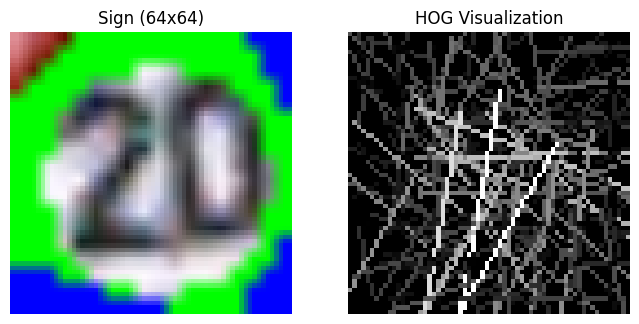

In [10]:
# Visualize HOG for first detected crop (if any)
if len(crops) > 0:
    feat, hog_vis = extract_hog_features(crops[0], visualize=True)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title('Sign (64x64)'); plt.imshow(cv2.cvtColor(cv2.resize(crops[0], (64,64)), cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(1,2,2); plt.title('HOG Visualization'); plt.imshow(hog_vis, cmap='gray'); plt.axis('off')
    plt.show()
else:
    print('No crops detected for HOG visualization.')

## 7) Build HOG feature dataset (Full pipeline)

Now we process all training images: enhance → segment → detect → choose best candidate (if multiple) → extract HOG. This will produce a feature matrix and labels. This step can be time-consuming for the full dataset.


In [7]:
# Function to process a single image and return a HOG vector (or None if not found)
def process_and_extract(img):
    enhanced = enhance_image(img)
    mask, seg = segment_colors(enhanced)
    regions = detect_shapes(enhanced, mask, debug=False)
    # If no region found, as fallback use center crop (GTSRB often has sign)
    if len(regions) == 0:
        h,w = img.shape[:2]
        size = min(h,w)
        cy,cx = h//2, w//2
        half = size//2
        crop = img[max(0,cy-half):min(h,cy+half), max(0,cx-half):min(w,cx+half)]
        regions = [crop]
    # Choose the largest region by area (simple heuristic)
    best = max(regions, key=lambda x: x.shape[0]*x.shape[1])
    feat = extract_hog_features(best)
    return feat

# WARNING: Running the following cell on the full dataset may take a long time.
# It's presented here but you can choose to run it. We'll demonstrate batching and timing.

run_full_extraction = False  # <-- Set to True if you want to run extraction now on the full dataset

if run_full_extraction:
    start = time.time()
    features_list = []
    labels_list = []
    for i, img in enumerate(images):
        if i % 500 == 0 and i > 0:
            print('Processed', i, 'images')
        feat = process_and_extract(img)
        if feat is None:
            continue
        features_list.append(feat)
        labels_list.append(labels[i])
    print('Total features extracted:', len(features_list))
    print('Time elapsed (s):', time.time() - start)
else:
    print('Full feature extraction skipped. To run, set run_full_extraction=True and re-run this cell.')    


Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images
Processed 8500 images
Processed 9000 images
Processed 9500 images
Processed 10000 images
Processed 10500 images
Processed 11000 images
Processed 11500 images
Processed 12000 images
Processed 12500 images
Processed 13000 images
Processed 13500 images
Processed 14000 images
Processed 14500 images
Processed 15000 images
Processed 15500 images
Processed 16000 images
Processed 16500 images
Processed 17000 images
Processed 17500 images
Processed 18000 images
Processed 18500 images
Processed 19000 images
Processed 19500 images
Processed 20000 images
Processed 20500 images
Processed 21000 images
Processed 21500 images
Processed 22000 images
Processe

## 8) Train SVM and Evaluate

After extracting features, split into train/test sets (or use provided splits). We'll train an RBF SVM with C=60 (as used in the paper) and evaluate accuracy. For demonstration we include GridSearch example (commented) and cross-validation.


In [ ]:
# Assuming features_list and labels_list exist from previous cell.
# For demonstration, we'll show the training steps with placeholders.
# If you have run full extraction, comment out the following demo data creation.

# if 'features_list' not in globals():
#     # Quick demo: extract features for first 300 images to allow quick training demonstration.
#     demo_n = 300
#     demo_features = []
#     demo_labels = []
#     for i in range(min(demo_n, len(images))):
#         f = process_and_extract(images[i])
#         if f is None:
#             continue
#         demo_features.append(f)
#         demo_labels.append(labels[i])
#     features_list = demo_features
#     labels_list = demo_labels
#     print('Built demo dataset with', len(features_list), 'samples for quick run.')

X = np.array(features_list)
y = np.array(labels_list)
print('Feature matrix shape:', X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM with RBF kernel and C=60
TRAIN_MODE = True  # <-- Set to True to enable training and evaluation
if TRAIN_MODE:
    clf = SVC(kernel='rbf', C=60, probability=False)
    start = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start
    print(f'Training completed in {train_time:.2f} seconds')

    # Evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test Accuracy:', acc)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))


Feature matrix shape: (39209, 1764)


### 8.1 Hyperparameter Comparison and Cross-Validation

Compare kernel choices (Linear, RBF, Sigmoid) quickly, and show K-Fold cross-validation for the chosen model.


In [ ]:
# fail safe added to make sure accidental training doesn't happen
TRAIN_MODE = False  # <-- Set to True to enable training and evaluation

if TRAIN_MODE:
    # Quick kernel comparison (small sample due to time)
    kernels = ['linear', 'rbf', 'sigmoid']
    results = {}

    # Find minimum samples per class in y_train
    unique, counts = np.unique(y_train, return_counts=True)
    min_samples_per_class_train = int(counts.min())

    # Determine cv_splits for kernel comparison (must be >=2 and <= min samples per class)
    if min_samples_per_class_train < 2:
        cv_splits = None
        print(f'Not enough samples per class in y_train for cross-validation (min={min_samples_per_class_train}). Skipping kernel comparison.')
    else:
        cv_splits = min(5, min_samples_per_class_train)

    for k in kernels:
        print('\n'+ '='*40)
        print(f'Cross-validating kernel: {k}')
        if cv_splits is None:
            results[k] = (None, None, None)
            continue
        clf_k = SVC(kernel=k, C=60)
        start = time.time()
        try:
            scores = cross_val_score(clf_k, X_train, y_train, cv=cv_splits, scoring='accuracy', n_jobs=1)
            results[k] = (scores.mean(), scores.std(), time.time()-start)
        except ValueError as e:
            results[k] = (None, None, None)
            print(f"Kernel {k} skipped due to cross-validation error: {e}")

    print('Kernel comparison (mean acc, std, time):')
    for k, v in results.items():
        print(k, v)

    # Cross-validation for final model (RBF) on the full dataset X,y
    unique_full, counts_full = np.unique(y, return_counts=True)
    min_samples_per_class_full = int(counts_full.min())

    if min_samples_per_class_full < 2:
        print(f"Cannot run StratifiedKFold: not enough samples in some classes (min samples per class = {min_samples_per_class_full}). Skipping full cross-validation.")
    else:
        n_splits = min(5, min_samples_per_class_full)
        if n_splits < 2:
            print(f"Computed n_splits={n_splits} is <2, skipping CV.")
        else:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            try:
                cv_scores = cross_val_score(SVC(kernel='rbf', C=60), X, y, cv=cv, scoring='accuracy', n_jobs=1)
                print(f'\n{n_splits}-fold CV scores for RBF SVM:', cv_scores)
                print('Mean CV accuracy:', cv_scores.mean())
            except ValueError as e:
                print('Full cross-validation skipped due to error:', e)



Cross-validating kernel: linear

Cross-validating kernel: rbf

Cross-validating kernel: sigmoid
Kernel comparison (mean acc, std, time):
linear (0.8531260593785033, 0.002886557833576077, 752.9731614589691)
rbf (0.9355373081379934, 0.0017288046990489255, 1575.3539192676544)
sigmoid (0.504256626338695, 0.008474410068103498, 719.9330689907074)

5-fold CV scores for RBF SVM: [0.94121398 0.9378985  0.94044887 0.94083142 0.9460528 ]
Mean CV accuracy: 0.9412891112675181


### 8.2 Confusion Matrix & Error Analysis

Display confusion matrix and some misclassified examples so we can discuss typical failure cases (occlusion, blur, reflection).


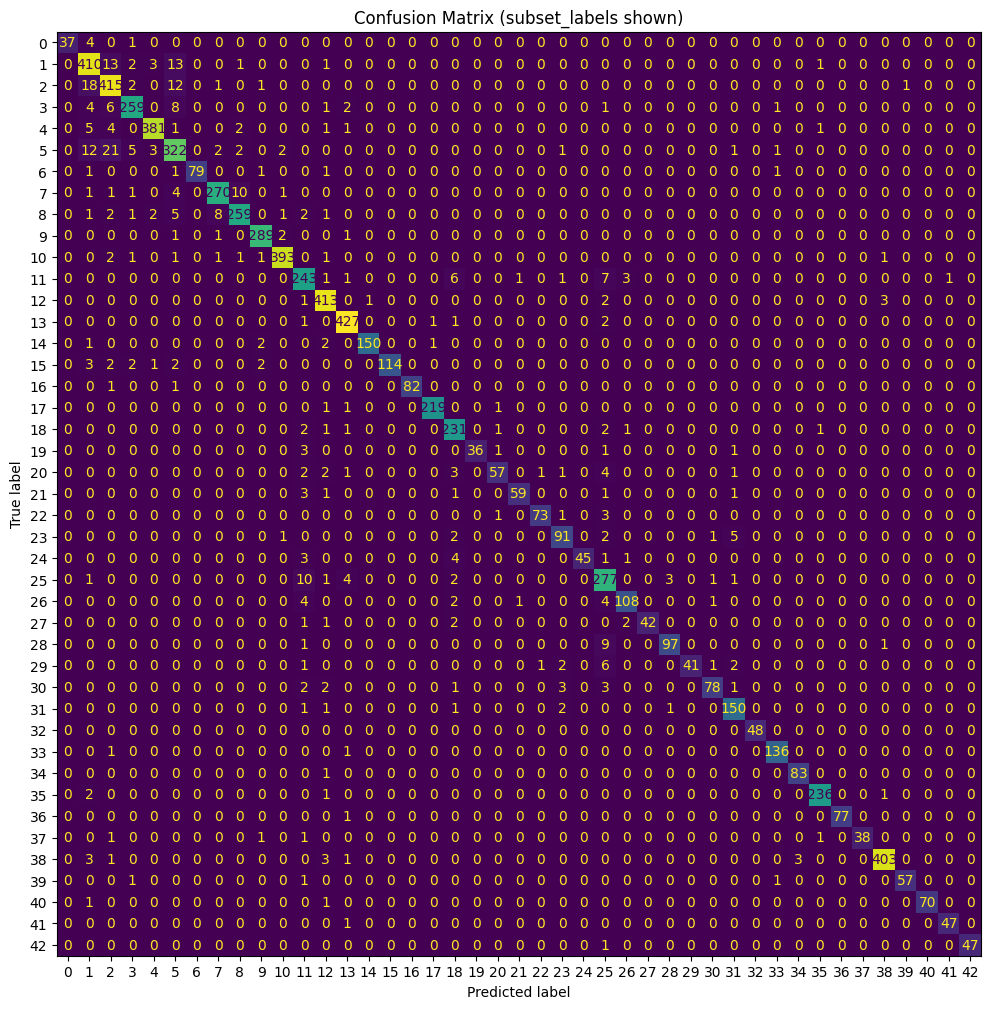

Number of misclassified samples: 453
Index 10: true=30, pred=25
Index 47: true=21, pred=25
Index 74: true=38, pred=1
Index 78: true=1, pred=2
Index 80: true=5, pred=31
Index 91: true=12, pred=38
Index 112: true=2, pred=1
Index 119: true=15, pred=9
Index 141: true=11, pred=25
Index 155: true=3, pred=1
Index 179: true=28, pred=25
Index 192: true=0, pred=1


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, cmap='viridis', colorbar=False)
plt.title('Confusion Matrix (subset_labels shown)')
plt.show()

# Show some misclassified examples
mis_idx = np.where(y_test != y_pred)[0]
print('Number of misclassified samples:', len(mis_idx))
for i in mis_idx[:12]:
    # We only have features; to display original image, approximate by mapping index to original
    # For demonstration we show HOG visualization of misclassified sample from X_test
    sample_feat = X_test[i]
    # We don't have the original crop readily associated in demo; instead, show details
    print(f'Index {i}: true={y_test[i]}, pred={y_pred[i]}')


## 9) Save the trained model

It's useful to save the trained SVM model (joblib) so we can reuse it for inference without retraining.


In [ ]:
model_path = 'svm_hog_gtsrb_rbf_c60_itr2.joblib'
TRAIN_MODE = True
if TRAIN_MODE:
    joblib.dump(clf, model_path)
    print('Saved model to', model_path)

## Predict using saved model


In [18]:
def load_model(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'Model file not found: {path}')
    model = joblib.load(path)
    return model

Test Accuracy: 0.08250446314715634

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00       444
           2       0.11      0.03      0.04       450
           3       0.31      0.01      0.03       282
           4       0.00      0.00      0.00       396
           5       0.12      0.02      0.03       372
           6       0.29      0.02      0.04        84
           7       0.00      0.00      0.00       288
           8       0.00      0.00      0.00       282
           9       0.01      0.00      0.00       294
          10       0.00      0.00      0.00       402
          11       0.06      0.16      0.08       264
          12       0.07      0.88      0.13       420
          13       0.22      0.37      0.28       432
          14       1.00      0.01      0.01       156
          15       0.50      0.01      0.02       126
          16       0.0

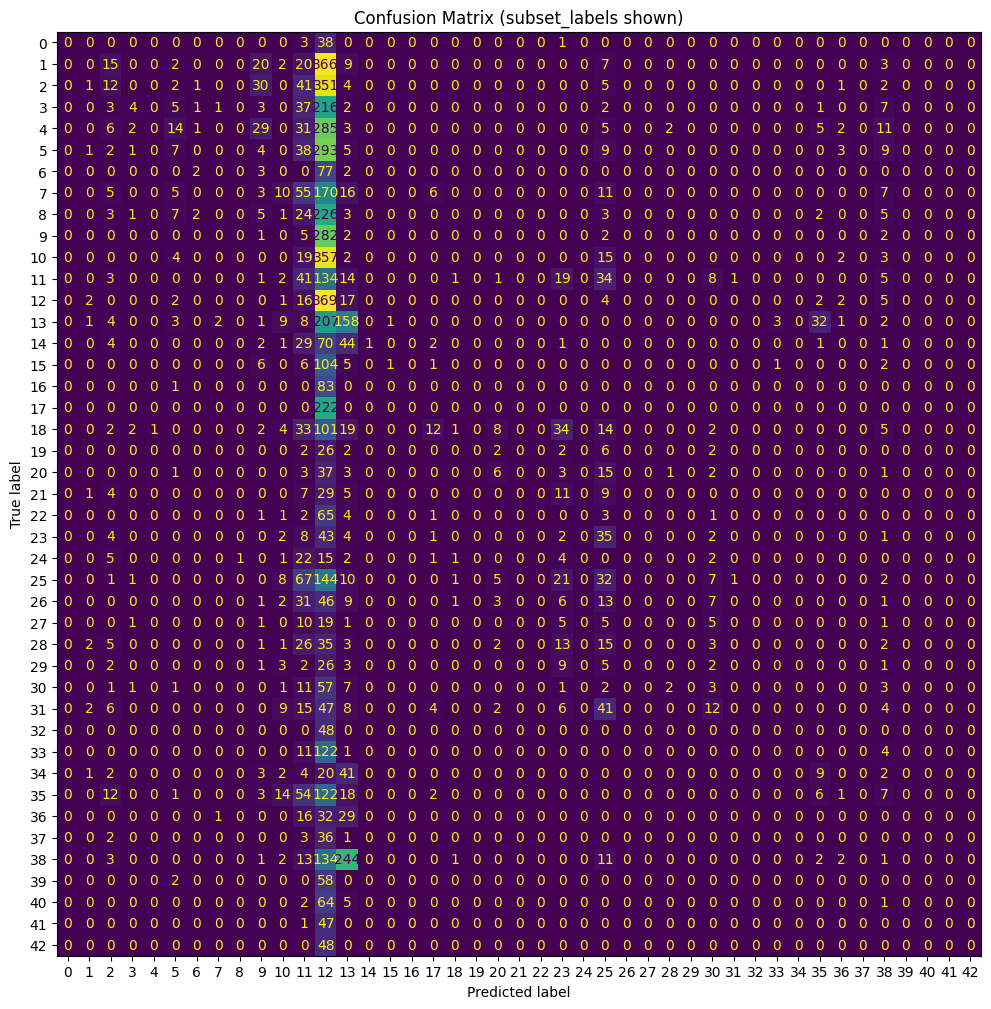

Number of misclassified samples: 7195
Index 0: true=28, pred=25
Index 1: true=2, pred=12
Index 2: true=1, pred=12
Index 3: true=25, pred=12
Index 4: true=38, pred=12
Index 5: true=9, pred=12
Index 6: true=31, pred=11
Index 7: true=12, pred=25
Index 8: true=1, pred=12
Index 9: true=4, pred=12
Index 11: true=9, pred=12
Index 12: true=25, pred=11


In [ ]:
TRAIN_MODE = True
if not TRAIN_MODE:
    clf = load_model(model_path)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test Accuracy:', acc)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax, cmap='viridis', colorbar=False)
    plt.title('Confusion Matrix (subset_labels shown)')
    plt.show()

    # Show some misclassified examples
    mis_idx = np.where(y_test != y_pred)[0]
    print('Number of misclassified samples:', len(mis_idx))
    for i in mis_idx[:12]:
        # We only have features; to display original image, approximate by mapping index to original
        # For demonstration we show HOG visualization of misclassified sample from X_test
        sample_feat = X_test[i]
        # We don't have the original crop readily associated in demo; instead, show details
        print(f'Index {i}: true={y_test[i]}, pred={y_pred[i]}')

## 10) Conclusion and Future Work

- We implemented the pipeline described in the paper: enhancement (YUV+CLAHE), color segmentation (HSV masks), shape detection (Hough+contours), HOG features, and SVM classifier.
- For a course project: include discussion on runtime, limitations (lighting, occlusion), and possible improvements such as using CNNs, hard-negative mining, and advanced segmentation.

**Good luck** with your submission! If you want, I can also run the full extraction and training on this environment, but it may take a long time depending on resources. Alternatively, you can download and run this notebook locally.
